In [1]:
#import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sklearn
#import itertools
from sklearn.decomposition import PCA
import time

from sklearn.model_selection             import train_test_split
from recommendation_evaluation_functions import recommend_ingredients, held_out_recommendation, calculate_metrics

%matplotlib inline

In [2]:
# Load data.
X        = pd.read_csv('train_dataset.csv', sep = '\t', index_col = 0).drop('cuisine', axis = 1)
cuisines = pd.read_csv('train_dataset.csv', sep = '\t', usecols = ['cuisine'])
cuisines.set_index(X.index, inplace = True)

## Evaluating a sample of recommendations

In [3]:
# Apply CF to original recipes.
recommendations = recommend_ingredients(X.head(1050), X.head(1050), similarity_measure = "jaccard", k = 5)

In [4]:
# Print some recipe + recommendation samples.
recipe1 = 7
recipe2 = 10

print('Recipe {} ({}): \n{}\n'.format(X.index[recipe1], 
                                      cuisines.iloc[recipe1, 0],
                                      X.columns[np.where(X.iloc[recipe1,] != 0)]))
print('Recommended ingredients: \n{}\n\n'.format(recommendations[5][recipe1,]))

print('Recipe {} ({}): \n{}\n'.format(X.index[recipe2], 
                                      cuisines.iloc[recipe2, 0],
                                      X.columns[np.where(X.iloc[recipe2,] != 0)]))
print('Recommended ingredients: \n{}\n\n'.format(recommendations[5][recipe2,]))

Recipe 16903 (mexican): 
Index(['cheddar_cheese', 'jalapeno_chilies', 'lettuce', 'lime', 'pork',
       'purple_onion', 'peppers', 'olive', 'cilantro_chopped_fresh',
       'pepper_ground_black', 'tortillas_corn'],
      dtype='object')

Recommended ingredients: 
Index(['kosher_salt', 'tortilla', 'garlic_cloves', 'cilantro_chopped',
       'garlic', 'vinegar', 'onions', 'crushed_pepper_flakes', 'beans_black',
       'chile'],
      dtype='object')


Recipe 45887 (chinese): 
Index(['canola', 'garlic', 'mustard', 'scallions', 'sesame', 'sugar', 'wine',
       'starch_corn', 'crushed_pepper_flakes', 'ginger_fresh', 'beans_green',
       'sodium_sauce', 'pepper_white'],
      dtype='object')

Recommended ingredients: 
Index(['vinegar_rice', 'onions_green', 'ginger', 'rice_wine', 'dry_sherry',
       'pork', 'yellow_onion', 'vegetable', 'vinegar',
       'skinless_boneless_chicken'],
      dtype='object')




## Model evaluation

**Split the data into train and test set**

In [5]:
X_train, X_test = train_test_split(X, test_size = 0.9, random_state = 1)

### Tune alpha parameter cosine similarity

In [72]:
# Initialise dataframe of results
results_alpha_PCA = pd.DataFrame(columns = ["k", "similarity_measure", "recall10", "mean_rank", 
                                            "median_rank"])

alpha_grid        = np.linspace(0.05,0.35,7)
user_item_matrix  = X_train

# Fix number of neighbours to 50 and use PCA to evaluate (roughly) the optimal value of alpha
model_config = [50, "asymmetric_cosine", len(X.columns)]

for alpha in alpha_grid:   
    
    missing_ingredients, recommendations = held_out_recommendation(user_item_matrix, model_config, usePCA = True,
                                                                   alpha = alpha)  
    for k, recs in recommendations.items():
        results_alpha_PCA = results_alpha_PCA.append(calculate_metrics(missing_ingredients, recs, 
                                                                       model_config[0],  
                                                                       model_config[1]),ignore_index = True)

In [133]:
results_alpha_PCA.to_csv('results/parameter_settings_train_alpha.csv', sep = '\t')

In [132]:
results_alpha_PCA = pd.read_csv('results/parameter_settings_train_alpha.csv', sep = '\t', index_col = 0)
results_alpha_PCA

,k,similarity_measure,top10_presence,mean_rank,median_rank
0,[50],asymmetric_cosine,0.446438,34.562935,12.0
1,[50],asymmetric_cosine,0.448581,33.978307,12.0
2,[50],asymmetric_cosine,0.448313,33.715854,13.0
3,[50],asymmetric_cosine,0.441885,33.510177,13.0
4,[50],asymmetric_cosine,0.439743,33.331280,13.0
5,[50],asymmetric_cosine,0.442421,33.380289,13.0
6,[50],asymmetric_cosine,0.439743,33.213444,13.0


### Without PCA

In [195]:
start_time = time.time()
results = pd.DataFrame(columns = ["k", "similarity_measure", "recall10", "mean_rank", "median_rank"])

k_grid              = [10, 20, 50, 100, 150, 200]
similarity_measures = ["cosine", "asymmetric_cosine", "jaccard", "pmi"]
n_recommendations   = len(X.columns)
user_item_matrix  = X_train

for sim in similarity_measures:
    
    model_config = [k_grid, sim, n_recommendations]
    missing_ingredients, recommendations = held_out_recommendation(user_item_matrix, model_config)
    
    for k, recs in recommendations.items():
        results = results.append(calculate_metrics(missing_ingredients, recs, k, sim), 
                                 ignore_index = True)    

print("--- %s minutes ---" % (round( (time.time() - start_time)/60, 3)))
results.to_csv('results/parameter_settings_train.csv', sep = '\t')

--- 141.428 minutes ---


In [196]:
results = pd.read_csv('results/parameter_settings_train.csv', sep = '\t', index_col = 0)
results

,k,similarity_measure,top10_presence,mean_rank,median_rank
0,10,cosine,0.289502,61.419122,30.0
1,20,cosine,0.316015,52.776915,26.0
2,50,cosine,0.314676,45.576593,23.0
3,100,cosine,0.287627,44.979914,25.0
4,150,cosine,0.245581,47.306106,30.0
5,200,cosine,0.225228,50.979646,35.0
6,10,asymmetric_cosine,0.280129,72.728709,32.0
7,20,asymmetric_cosine,0.301018,60.037761,27.0
8,50,asymmetric_cosine,0.316015,49.785217,25.0
9,100,asymmetric_cosine,0.286020,46.640332,25.0


### Same settings, with PCA

In [197]:
start_time = time.time()
results_PCA = pd.DataFrame(columns = ["k", "similarity_measure", "recall10", "mean_rank", "median_rank"])

k_grid              = [10, 20, 50, 100, 150, 200]
similarity_measures = ["cosine", "asymmetric_cosine", "jaccard", "pmi"]
n_recommendations   = len(X.columns)
user_item_matrix  = X_train

for sim in similarity_measures:
    
    model_config = [k_grid, sim, n_recommendations]
    missing_ingredients, recommendations = held_out_recommendation(user_item_matrix, model_config, usePCA = True)
    
    for k, recs in recommendations.items():
        results_PCA = results_PCA.append(calculate_metrics(missing_ingredients, recs, k, sim), 
                            ignore_index = True)
        
print("--- %s minutes ---" % (round( (time.time() - start_time)/60, 3)))
results_PCA.to_csv('results/parameter_settings_train_PCA.csv', sep = '\t')


--- 12.083 minutes ---


In [214]:
results_PCA = pd.read_csv('results/parameter_settings_train_PCA.csv', sep = '\t', index_col = 0)
results_PCA

,k,similarity_measure,top10_presence,mean_rank,median_rank
0,10,cosine,0.380557,54.132566,18.0
1,20,cosine,0.408945,41.655329,15.0
2,50,cosine,0.432780,33.290305,13.0
3,100,cosine,0.427424,32.005624,13.0
4,150,cosine,0.419122,34.908141,14.0
5,200,cosine,0.411623,38.991698,15.0
6,10,asymmetric_cosine,0.386181,59.019550,18.0
7,20,asymmetric_cosine,0.421800,44.261650,14.0
8,50,asymmetric_cosine,0.441885,33.510177,13.0
9,100,asymmetric_cosine,0.441618,31.544992,12.0


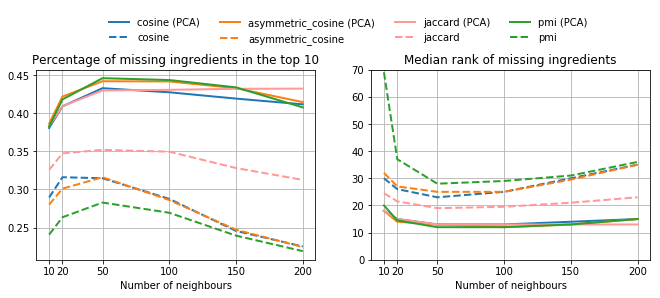

In [220]:
top10_pca       = results_PCA['recall10_presence']
top10           = results    ['recall10_presence']
median_pca      = results_PCA['median_rank']
median          = results    ['median_rank']

color_sequence = ['#1f77b4', '#ff7f0e', '#ff9896', '#2ca02c']

fig, ax = plt.subplots(1, 2, sharex=True, figsize=(11, 3.5))

for sim, color in zip(similarity_measures, color_sequence):
    ax[0].plot(k_grid, top10_pca.loc[results_PCA['similarity_measure'] == sim], color, 
             linewidth = 2, label = sim + ' (PCA)')
    ax[0].plot(k_grid, top10.loc[results['similarity_measure'] == sim], color, linewidth = 2, 
             linestyle = "--", label = sim)
    ax[1].plot(k_grid, median_pca.loc[results_PCA['similarity_measure'] == sim], color, 
               linewidth = 2, label = sim + ' (PCA)')
    ax[1].plot(k_grid, median.loc[results['similarity_measure'] == sim], color, linewidth = 2, 
             linestyle = "--", label = sim)

ax[1].set_ylim((0,70))

for i in [0,1]:
    ax[i].grid(); 
    ax[i].set_xlabel('Number of neighbours')


ax[0].set_title("Percentage of missing ingredients in the top 10")
ax[1].set_title("Median rank of missing ingredients")

ax[1].set_xticks(k_grid)

handles, labels = ax[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', frameon=False, ncol=4, bbox_to_anchor = (0.44,1.15))

plt.show()
fig.savefig('plots/k_tuning.pdf', bbox_inches="tight")

After applying PCA, the results improve considerably and become less senstive to the similarity measure and the k (especially for high values of k)

## Run all similarity metrics with best k and PCA (50)

In [221]:
results_model_sel = pd.DataFrame(columns = ["k", "similarity_measure", "recall10, 
                                            "mean_rank", "median_rank"])
k_grid              = [50]
similarity_measures = ["cosine", "asymmetric_cosine", "jaccard", "pmi"]
n_recommendations   = len(X.columns)
user_item_matrix    = X_test

for sim in similarity_measures:
    
    model_config = [k_grid, sim, n_recommendations]
    missing_ingredients, recommendations = held_out_recommendation(user_item_matrix, model_config, usePCA = True)
    
    for k, recs in recommendations.items():
        results_model_sel = results_model_sel.append(calculate_metrics(missing_ingredients, recs, k, sim), 
                            ignore_index = True)

In [222]:
results_model_sel.to_csv('results/model_selection_PCA_k_50.csv', sep = '\t')

In [223]:
results_model_sel = pd.read_csv('results/model_selection_PCA_k_50.csv', sep = '\t', index_col = 0)
results_model_sel

,k,similarity_measure,top10_presence,mean_rank,median_rank
0,50,cosine,0.392638,40.913081,16.0
1,50,asymmetric_cosine,0.401625,41.690115,15.0
2,50,jaccard,0.392608,41.222222,16.0
3,50,pmi,0.402517,42.728114,15.0


## Sample predictions from our best model

In [39]:
n       = X.shape[0]
pca     = PCA(n_components = n)
X_pca_T = pca.fit_transform(X.T)
X_pca   = pd.DataFrame(X_pca_T.T, columns = X.columns)

In [211]:
recommendations = recommend_ingredients(X.head(11), X_pca, similarity_measure = "pmi", k = 50)

In [212]:
recipe1 = 7
recipe2 = 3

print('Recipe {} ({}): \n{}\n'.format(X.index[recipe1], 
                                      cuisines.iloc[recipe1, 0],
                                      X.columns[np.where(X.iloc[recipe1,] != 0)]))
print('Recommended ingredients: \n{}\n\n'.format(recommendations[50][recipe1,]))

print('Recipe {} ({}): \n{}\n'.format(X.index[recipe2], 
                                      cuisines.iloc[recipe2, 0],
                                      X.columns[np.where(X.iloc[recipe2,] != 0)]))
print('Recommended ingredients: \n{}\n\n'.format(recommendations[50][recipe2,]))

Recipe 16903 (mexican): 
Index(['cheddar_cheese', 'jalapeno_chilies', 'lettuce', 'lime', 'pork',
       'purple_onion', 'peppers', 'olive', 'cilantro_chopped_fresh',
       'pepper_ground_black', 'tortillas_corn'],
      dtype='object')

Recommended ingredients: 
Index(['avocado', 'cilantro', 'tomatoes', 'juice_fresh_lime', 'kosher_salt',
       'cream_sour', 'cilantro_fresh', 'corn', 'salsa', 'ground_cumin'],
      dtype='object')


Recipe 13162 (indian): 
Index(['butter', 'cayenne_pepper', 'cream', 'garlic_paste', 'ground_cumin',
       'masala', 'milk', 'oil', 'onions', 'shallots', 'pepper_black',
       'skinless_boneless_chicken', 'powder_chili', 'yogurt', 'juice_lemon'],
      dtype='object')

Recommended ingredients: 
Index(['paprika', 'chilies_green', 'coriander_ground', 'chicken', 'flour',
       'potatoes', 'cilantro_leaves', 'pepper', 'garlic', 'cumin_seed'],
      dtype='object')


